1 线性回归的从零开始实现（不适用任何深度学习框架提供的计算，只使用在tensor上面的计算实现算法和技术细节）

    我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器 

In [2]:
%matplotlib inline：plot时默认嵌入到mat lookbook里面
import random#随机梯度下降，随机初始化权重
import torch
from d2l import torch as d2l#讲过的一些函数

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数  $w=[2,-3.4]^T$、$b=4.2$和噪声项$\epsilon$生成数据集及其标签： 
$y=Xw+b+\epsilon$


In [6]:
def synthetic_data(w,b,num_examples):#num_examples:样本个数
        """生成 y =Xw+b+噪声。"""
        x = torch.normal(0,1,(num_examples,len(w)))#均值为0方差为1的随机数（标准正态分布），num_examples个样本，长度为w的长度
        y = torch.matmul(x,w)+b
        y+= torch.normal(0,0.01,y.shape)#形状和y一样
        return x,y.reshape((-1,1))#做成一个列向量返回
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [7]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([ 1.0777, -1.1017]) 
label: tensor([10.1061])


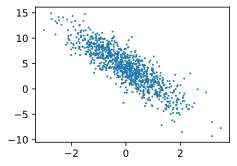

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);#detach：从计算图中detach出来，然后才能转到numpy中

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量 

In [11]:
def data_iter(batch_size, features, labels):
        num_examples = len(features)
        indices = list (range(num_examples))#生成对每个样本的index，range从0到n-1，然后转成python的list
        #样本随机读取，无特定顺序
        random.shuffle(indices)#完全打乱这些下标——随机顺序访问样本
        for i in range(0, num_examples, batch_size):#从0开始到n-1，每次跳batch_size个大小
                batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])#取出i到min(i+batch_size,num_examples)中的这些indices
                yield features[batch_indices],labels[batch_indices]#根据batch_index产生随机顺序的特征及其对应标号，yield：python的一个iterator
batch_size = 10

for X, y in data_iter(batch_size,features, labels):
    print(X,'\n',y)
    break

tensor([[ 0.7421, -0.1565],
        [-0.1875, -0.3187],
        [-0.9514, -0.0245],
        [-0.6504, -0.1369],
        [ 0.5759,  0.6772],
        [ 0.7338, -0.5581],
        [ 1.0463, -2.1630],
        [-1.3399, -1.9435],
        [-0.8174,  0.0961],
        [-1.5093, -1.2677]]) 
 tensor([[ 6.2136],
        [ 4.8979],
        [ 2.3935],
        [ 3.3594],
        [ 3.0578],
        [ 7.5585],
        [13.6490],
        [ 8.1246],
        [ 2.2528],
        [ 5.4862]])


定义 初始化模型参数

In [12]:
w = torch.normal(0,0.01,size=(2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

定义模型

In [13]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

定义损失函数

In [16]:
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

定义优化算法

In [17]:
def sgd(params,lr,batch_size):#lr:学习率
    """小批量随机梯度下降"""
    with torch.no_grad():#不需要计算梯度
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()#梯度置为0？

训练过程

In [22]:
#lr = 0.03
#lr = 0.01
lr = 10
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y)#X和y的小批量损失
        #因为l的形状是（'batch_size',1），而不是一个标量。l中的所有元素被加到一起并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)#使用参数的梯度更新
    with torch.no_grad():
        train_l = loss(net(features, w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss nan
epoch 2,loss nan
epoch 3,loss nan


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [21]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'w的估计误差：{true_b-b}')

w的估计误差：tensor([-0.0002, -0.0001], grad_fn=<SubBackward0>)
w的估计误差：tensor([0.0003], grad_fn=<RsubBackward1>)


实验一下不同的超参数有什么不同效果(lr,w,num_epochs)